In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, SelectFromModel, RFE

In [2]:
MODEL_1_FILE_PATH = '../model1.pkl'
MODEL_2_FILE_PATH = '../model2.pkl'
MODEL_3_FILE_PATH = '../model3.pkl'

In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

In [4]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [5]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
TRAIN_DATASET_PATH = '../course_project_train.csv'
TEST_DATASET_PATH = '../course_project_test.csv'

In [8]:
TARGET_NAME = 'Credit Default'

In [9]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [10]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


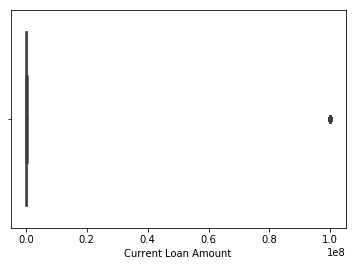

In [11]:
sns.boxplot(df_train['Current Loan Amount'])

In [12]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

## Анализ целевой переменной

In [15]:
TARGET_NAME = 'Credit Default'

In [16]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

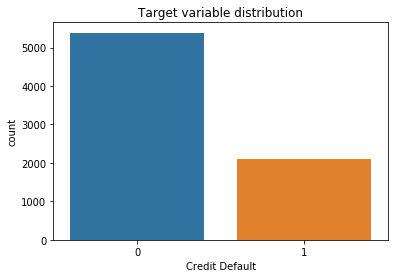

In [17]:
plt.figure(figsize=(6, 4))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

## Работа с категориальными переменными

### Работа с Purpose

In [18]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [19]:
term_with_target = df_train[['Purpose', 'Credit Default']]#.sample(1000)
term_with_target = term_with_target.reset_index()

In [20]:
table = term_with_target.pivot_table(values='index', index='Purpose', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Purpose,,
business loan,74.0,55.0
buy a car,72.0,24.0
buy house,25.0,9.0
debt consolidation,4290.0,1654.0
educational expenses,9.0,1.0
home improvements,304.0,108.0
major purchase,31.0,9.0
medical bills,49.0,22.0
moving,9.0,2.0


разделим на 3 класса: в одном больше погасили кредит, во втором - нет

class1: business loan + renewable energy + small business


class2: debt consolidation + other + medical bills

class3: buy a car + buy house + educational expenses + home improvements + major purchase + take a trip + vacation + wedding

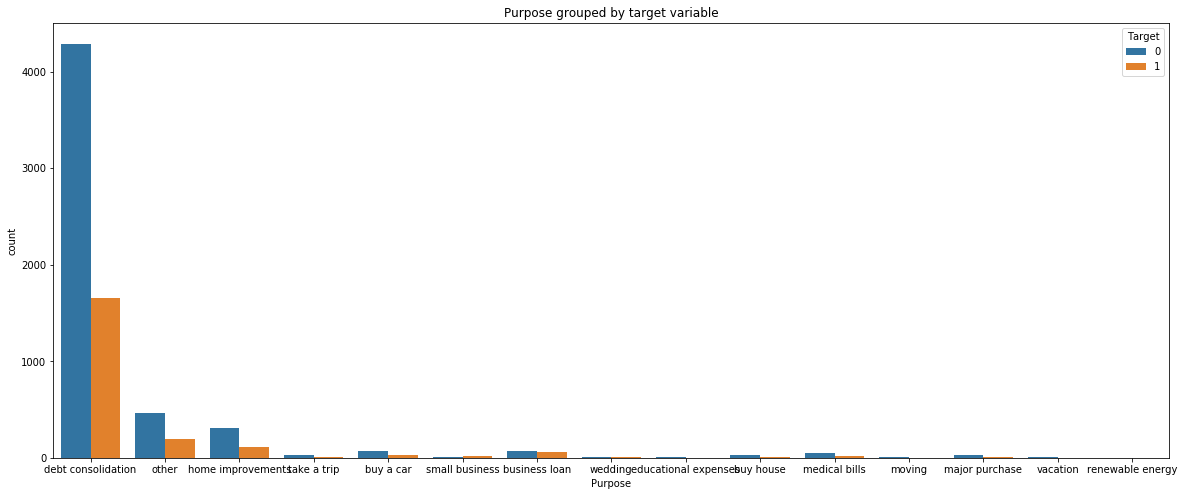

In [21]:
plt.figure(figsize=(20, 8))
sns.countplot(x="Purpose", hue='Credit Default', data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

In [22]:
df_train.loc[df_train['Purpose'] == 'business loan', ['Purpose']] = 'Class1'
df_train.loc[df_train['Purpose'] == 'renewable energy', ['Purpose']] = 'Class1'
df_train.loc[df_train['Purpose'] == 'small business', ['Purpose']] = 'Class1'

In [23]:
df_train.loc[df_train['Purpose'] == 'debt consolidation', ['Purpose']] = 'Class2'
df_train.loc[df_train['Purpose'] == 'other', ['Purpose']] = 'Class2'
df_train.loc[df_train['Purpose'] == 'medical bills', ['Purpose']] = 'Class2'

df_train.loc[df_train['Purpose'] == 'buy a car', ['Purpose']] = 'Class2'
df_train.loc[df_train['Purpose'] == 'buy house', ['Purpose']] = 'Class2'
df_train.loc[df_train['Purpose'] == 'educational expenses', ['Purpose']] = 'Class2'

df_train.loc[df_train['Purpose'] == 'home improvements', ['Purpose']] = 'Class2'
df_train.loc[df_train['Purpose'] == 'major purchase', ['Purpose']] = 'Class2'
df_train.loc[df_train['Purpose'] == 'take a trip', ['Purpose']] = 'Class2'

df_train.loc[df_train['Purpose'] == 'vacation', ['Purpose']] = 'Class2'
df_train.loc[df_train['Purpose'] == 'wedding', ['Purpose']] = 'Class2'
df_train.loc[df_train['Purpose'] == 'moving', ['Purpose']] = 'Class2'

In [24]:
df_test.loc[df_test['Purpose'] == 'business loan', ['Purpose']] = 'Class1'
df_test.loc[df_test['Purpose'] == 'renewable energy', ['Purpose']] = 'Class1'
df_test.loc[df_test['Purpose'] == 'small business', ['Purpose']] = 'Class1'

In [25]:
df_test.loc[df_test['Purpose'] == 'debt consolidation', ['Purpose']] = 'Class2'
df_test.loc[df_test['Purpose'] == 'other', ['Purpose']] = 'Class2'
df_test.loc[df_test['Purpose'] == 'medical bills', ['Purpose']] = 'Class2'

df_test.loc[df_test['Purpose'] == 'buy a car', ['Purpose']] = 'Class2'
df_test.loc[df_test['Purpose'] == 'buy house', ['Purpose']] = 'Class2'
df_test.loc[df_test['Purpose'] == 'educational expenses', ['Purpose']] = 'Class2'

df_test.loc[df_test['Purpose'] == 'home improvements', ['Purpose']] = 'Class2'
df_test.loc[df_test['Purpose'] == 'major purchase', ['Purpose']] = 'Class2'
df_test.loc[df_test['Purpose'] == 'take a trip', ['Purpose']] = 'Class2'

df_test.loc[df_test['Purpose'] == 'vacation', ['Purpose']] = 'Class2'
df_test.loc[df_test['Purpose'] == 'wedding', ['Purpose']] = 'Class2'
df_test.loc[df_test['Purpose'] == 'moving', ['Purpose']] = 'Class2'

In [26]:
term_with_target = df_train[['Purpose', 'Credit Default']]#.sample(1000)
term_with_target = term_with_target.reset_index()

In [27]:
table = term_with_target.pivot_table(values='index', index='Purpose', columns='Credit Default', aggfunc='count')

In [28]:
table

Credit Default,0,1
Purpose,,
Class1,86,71
Class2,5301,2042


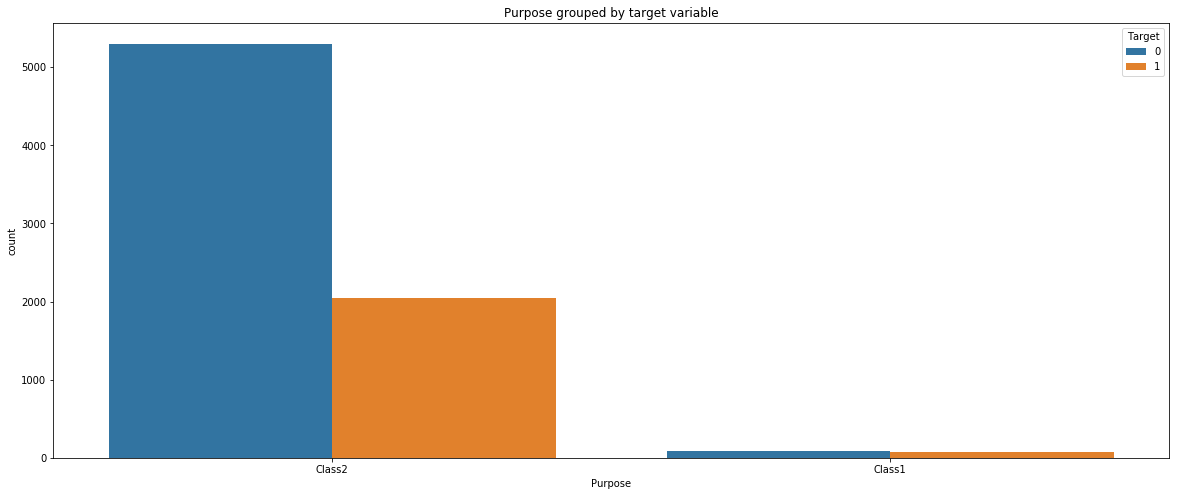

In [29]:
plt.figure(figsize=(20, 8))
sns.countplot(x="Purpose", hue='Credit Default', data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

### Работа с Tax Liens

In [30]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [31]:
term_with_target = df_train[['Tax Liens', 'Credit Default']]#.sample(1000)
term_with_target = term_with_target.reset_index()
table = term_with_target.pivot_table(values='index', index='Tax Liens', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
0.0,5301.0,2065.0
1.0,59.0,24.0
2.0,15.0,15.0
3.0,5.0,5.0
4.0,3.0,3.0
5.0,1.0,1.0
6.0,2.0,NaN
7.0,1.0,NaN


In [32]:
a = df_train.loc[df_train['Credit Default'] == 0, 'Tax Liens'].reset_index()
b = df_train.loc[df_train['Credit Default'] == 1, 'Tax Liens'].reset_index()

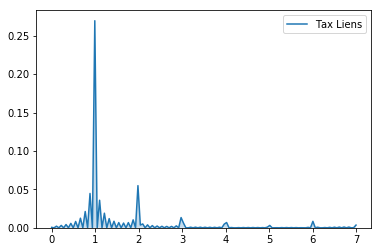

In [33]:
sns.kdeplot(a['Tax Liens'], shade=True)

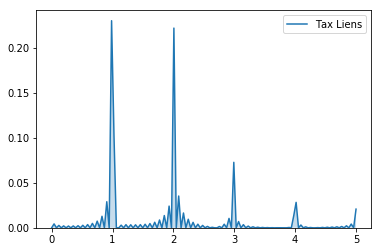

In [34]:
sns.kdeplot(b['Tax Liens'], shade=True)

In [35]:
df_train.loc[df_train['Tax Liens'] <= 1.1, ['Tax Liens']] = 'Less_equ_1'
df_train.loc[df_train['Tax Liens'] != 'Less_equ_1', ['Tax Liens']] = 'More_equ_2'

In [36]:
df_test.loc[df_test['Tax Liens'] <= 1.1, ['Tax Liens']] = 'Less_equ_1'
df_test.loc[df_test['Tax Liens'] != 'Less_equ_1', ['Tax Liens']] = 'More_equ_2'

In [37]:
term_with_target = df_train[['Tax Liens', 'Credit Default']]#.sample(1000)
term_with_target = term_with_target.reset_index()
table = term_with_target.pivot_table(values='index', index='Tax Liens', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Tax Liens,,
Less_equ_1,5360,2089
More_equ_2,27,24


### Работа с Number of Open Accounts

In [38]:
term_with_target = df_train[['Number of Open Accounts', 'Credit Default']]#.sample(1000)
term_with_target = term_with_target.reset_index()
table = term_with_target.pivot_table(values='index', index='Number of Open Accounts', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Open Accounts,,
2.0,19.0,9.0
3.0,71.0,24.0
4.0,156.0,56.0
5.0,231.0,94.0
6.0,374.0,130.0
7.0,455.0,158.0
8.0,480.0,158.0
9.0,513.0,215.0
10.0,480.0,197.0


In [39]:
a = df_train.loc[df_train['Credit Default'] == 0, 'Number of Open Accounts'].reset_index()

In [40]:
b = df_train.loc[df_train['Credit Default'] == 1, 'Number of Open Accounts'].reset_index()

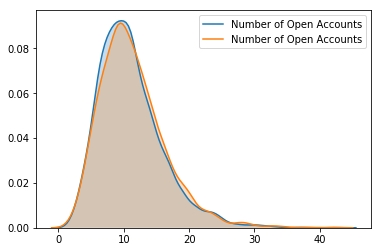

In [41]:
sns.kdeplot(a['Number of Open Accounts'], shade=True)
sns.kdeplot(b['Number of Open Accounts'], shade=True)

Очень сложно разделить

### Работа с Number of Credit Problems

In [42]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [43]:
term_with_target = df_train[['Number of Credit Problems', 'Credit Default']]#.sample(1000)
term_with_target = term_with_target.reset_index()
table = term_with_target.pivot_table(values='index', index='Number of Credit Problems', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Number of Credit Problems,,
0.0,4654.0,1815.0
1.0,641.0,241.0
2.0,60.0,33.0
3.0,21.0,14.0
4.0,3.0,6.0
5.0,3.0,4.0
6.0,4.0,NaN
7.0,1.0,NaN


In [44]:
df_train.loc[df_train['Number of Credit Problems'] <= 3.5, ['Number of Credit Problems']] = 'Less_equ_3'
df_train.loc[df_train['Number of Credit Problems'] != 'Less_equ_3', ['Number of Credit Problems']] = 'More_equ_4'

In [45]:
df_test.loc[df_test['Number of Credit Problems'] <= 3.5, ['Number of Credit Problems']] = 'Less_equ_3'
df_test.loc[df_test['Number of Credit Problems'] != 'Less_equ_3', ['Number of Credit Problems']] = 'More_equ_4'

### Работа с Bankruptcies

In [46]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [47]:
term_with_target = df_train[['Bankruptcies', 'Credit Default']]#.sample(1000)
term_with_target = term_with_target.reset_index()
table = term_with_target.pivot_table(values='index', index='Bankruptcies', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Bankruptcies,,
0.0,4782,1878
1.0,569,217
2.0,20,11
3.0,5,2
4.0,1,1


Если разделять , то во втором классе получится очень мало значений, поэтому нет смысла

## Слияние df_train и df_test для одновременной обработки

In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null object
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null object
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(10), object(6)
memo

In [49]:
y_df = df_train[TARGET_NAME]

In [50]:
df_train = df_train.drop(TARGET_NAME, axis=1)

In [51]:
df_train.shape

(7500, 16)

In [52]:
df_test.shape

(2500, 16)

In [53]:
df = pd.concat([df_train, df_test], axis=0).reset_index()

In [54]:
df

,index,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,0,Own Home,482087.0,NaN,Less_equ_1,11.0,26.3,685960.0,Less_equ_3,NaN,1.0,Class2,Short Term,99999999.0,47386.0,7914.0,749.0
1,1,Own Home,1025487.0,10+ years,Less_equ_1,15.0,15.3,1181730.0,Less_equ_3,NaN,0.0,Class2,Long Term,264968.0,394972.0,18373.0,737.0
2,2,Home Mortgage,751412.0,8 years,Less_equ_1,11.0,35.0,1182434.0,Less_equ_3,NaN,0.0,Class2,Short Term,99999999.0,308389.0,13651.0,742.0
3,3,Own Home,805068.0,6 years,Less_equ_1,8.0,22.5,147400.0,Less_equ_3,NaN,1.0,Class2,Short Term,121396.0,95855.0,11338.0,694.0
4,4,Rent,776264.0,8 years,Less_equ_1,13.0,13.6,385836.0,Less_equ_3,NaN,0.0,Class2,Short Term,125840.0,93309.0,7180.0,719.0
5,5,Rent,NaN,7 years,Less_equ_1,12.0,14.6,366784.0,Less_equ_3,NaN,0.0,Class2,Long Term,337304.0,165680.0,18692.0,NaN
6,6,Home Mortgage,1511108.0,10+ years,Less_equ_1,9.0,20.3,388124.0,Less_equ_3,73.0,0.0,Class2,Short Term,99999999.0,51623.0,2317.0,745.0
7,7,Rent,1040060.0,10+ years,Less_equ_1,13.0,12.0,330374.0,Less_equ_3,18.0,0.0,Class2,Short Term,250888.0,89015.0,19761.0,705.0
8,8,Home Mortgage,NaN,5 years,Less_equ_1,17.0,15.7,0.0,Less_equ_3,NaN,1.0,Class2,Short Term,129734.0,19.0,17.0,NaN
9,9,Home Mortgage,NaN,1 year,Less_equ_1,10.0,24.6,511302.0,Less_equ_3,6.0,0.0,Class2,Long Term,572880.0,205333.0,17613.0,NaN


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
index                           10000 non-null int64
Home Ownership                  10000 non-null object
Annual Income                   7930 non-null float64
Years in current job            9543 non-null object
Tax Liens                       10000 non-null object
Number of Open Accounts         10000 non-null float64
Years of Credit History         10000 non-null float64
Maximum Open Credit             10000 non-null float64
Number of Credit Problems       10000 non-null object
Months since last delinquent    4561 non-null float64
Bankruptcies                    9983 non-null float64
Purpose                         10000 non-null object
Term                            10000 non-null object
Current Loan Amount             10000 non-null float64
Current Credit Balance          10000 non-null float64
Monthly Debt                    10000 non-null float64
Credit Score            

## Работа с категориальными переменными

### Работа с years in current job

In [56]:
# df.loc[df['Years in current job']=='10+ years', 'Years in current job'] = 10
# df.loc[df['Years in current job']=='9 years', 'Years in current job'] = 9
# df.loc[df['Years in current job']=='8 years', 'Years in current job'] = 8
# df.loc[df['Years in current job']=='7 years', 'Years in current job'] = 7
# df.loc[df['Years in current job']=='6 years', 'Years in current job'] = 6
# df.loc[df['Years in current job']=='5 years', 'Years in current job'] = 5
# df.loc[df['Years in current job']=='4 years', 'Years in current job'] = 4
# df.loc[df['Years in current job']=='3 years', 'Years in current job'] = 3
# df.loc[df['Years in current job']=='2 years', 'Years in current job'] = 2
# df.loc[df['Years in current job']=='1 year', 'Years in current job'] = 1
# df.loc[df['Years in current job']=='< 1 year', 'Years in current job'] = 0
# df['Years in current job'] = df['Years in current job'].astype("float64")
# df.loc[df['Years in current job'].isnull(), 'Years in current job'] = df['Years in current job'].mean()

## Устранение выбросов

### Нет выбросов в 'Monthly Debt

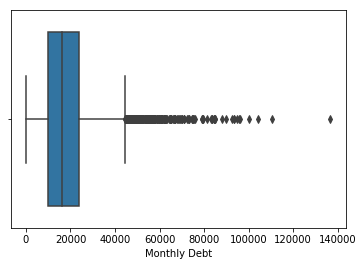

In [57]:
sns.boxplot(df['Monthly Debt'])

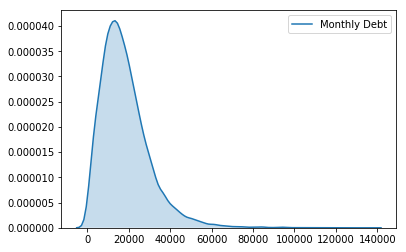

In [58]:
sns.kdeplot(df['Monthly Debt'], shade=True)

### Устраняем выбросы в Maximum Open Credit

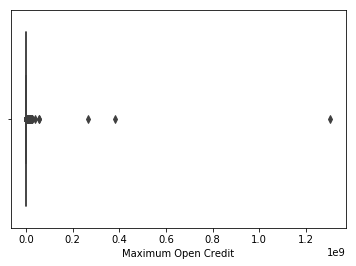

In [59]:
sns.boxplot(x=df['Maximum Open Credit'])

In [60]:
# Надо поэкспериментировать с этим параметром

In [61]:
# ver1
df.loc[df['Maximum Open Credit']>0.2*1e9, ['Maximum Open Credit']] = df['Maximum Open Credit'].median()

# ver2
#df.loc[df['Maximum Open Credit']>1*1e7, ['Maximum Open Credit']] = df['Maximum Open Credit'].median()
#df.loc[df['Maximum Open Credit']<0, ['Maximum Open Credit']] = df['Maximum Open Credit'].median()

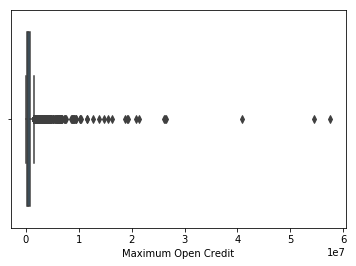

In [62]:
sns.boxplot(x=df['Maximum Open Credit'])

### Устраняем выбросы в Current Loan Amount

In [63]:
# 10% значений ощибочны (9999999999). Заменим их NaN, чтобы в дальнейшем восстановить регрессией
df.loc[df['Current Loan Amount']>1e7, 'Current Loan Amount'].count()

1167

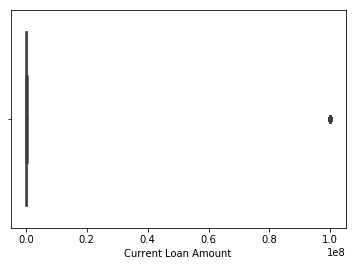

In [64]:
sns.boxplot(x=df['Current Loan Amount'])

In [65]:
#new = df['Current Loan Amount'].median()

In [66]:
#df.loc[df['Current Loan Amount'] > 0.4*1e8, ['Current Loan Amount']] = new

In [67]:
df.loc[df['Current Loan Amount'] > 0.4*1e8, ['Current Loan Amount']] = np.NaN

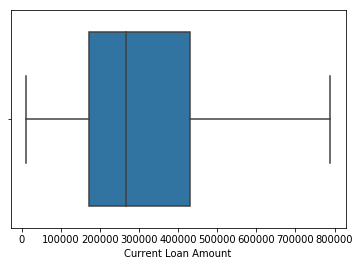

In [68]:
sns.boxplot(x=df['Current Loan Amount'])

### Устраняем выбросы в Credit Score

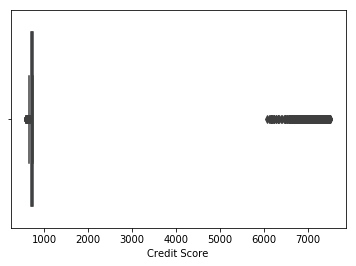

In [69]:
sns.boxplot(x=df['Credit Score'])

In [70]:
high_values = df.loc[df['Credit Score']>5000, ['Credit Score']]

In [71]:
high_values = high_values/10

In [72]:
df.loc[df['Credit Score']>5000, ['Credit Score']] = high_values

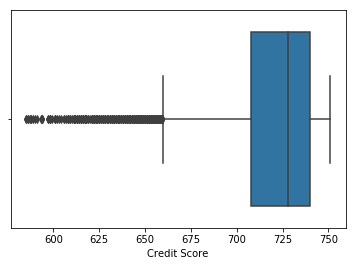

In [73]:
sns.boxplot(x=df['Credit Score'])

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
index                           10000 non-null int64
Home Ownership                  10000 non-null object
Annual Income                   7930 non-null float64
Years in current job            9543 non-null object
Tax Liens                       10000 non-null object
Number of Open Accounts         10000 non-null float64
Years of Credit History         10000 non-null float64
Maximum Open Credit             10000 non-null float64
Number of Credit Problems       10000 non-null object
Months since last delinquent    4561 non-null float64
Bankruptcies                    9983 non-null float64
Purpose                         10000 non-null object
Term                            10000 non-null object
Current Loan Amount             8833 non-null float64
Current Credit Balance          10000 non-null float64
Monthly Debt                    10000 non-null float64
Credit Score             

## Нормализация распределений

### Нормализация Number of Open Accounts

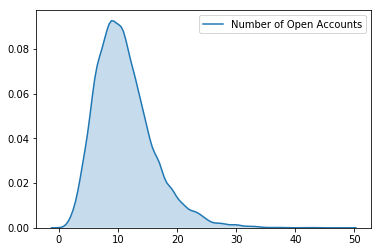

In [75]:
sns.kdeplot(df['Number of Open Accounts'], shade=True)

In [76]:
xt, _ = stats.boxcox(df['Number of Open Accounts'])

In [77]:
df['Number of Open Accounts'] = xt

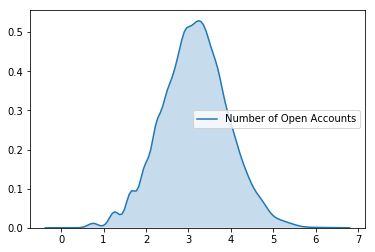

In [78]:
sns.kdeplot(df['Number of Open Accounts'], shade=True)

### Нормализация Years of Credit History

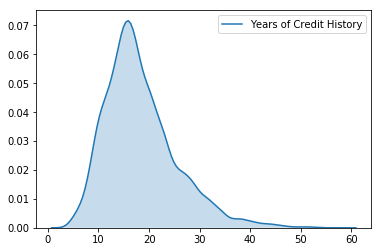

In [79]:
sns.kdeplot(df['Years of Credit History'], shade=True)

In [80]:
xt, _ = stats.boxcox(df['Years of Credit History'])

In [81]:
df['Years of Credit History'] = xt

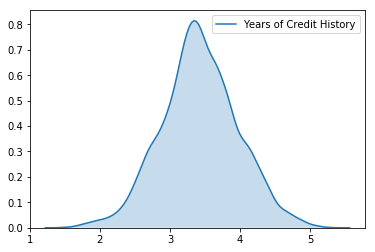

In [82]:
sns.kdeplot(df['Years of Credit History'], shade=True)

### Нормализация Current Credit Balance (точнсть снизилась)

In [83]:
#sns.kdeplot(df['Current Credit Balance'], shade=True)

In [84]:
# Так точность снизилась
#df['Current Credit Balance'] = df['Current Credit Balance']**0.2

In [85]:
#df['Current Credit Balance'] = df['Current Credit Balance'] + 1

In [86]:
#xt, _ = stats.boxcox(df['Current Credit Balance'])

In [87]:
#df['Current Credit Balance'] = xt

In [88]:
#sns.kdeplot(df['Current Credit Balance'], shade=True)

### Нормализация Monthly Debt

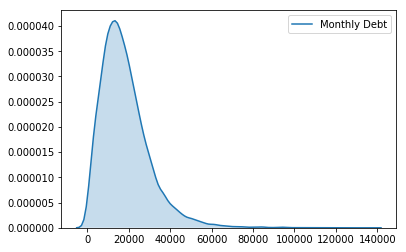

In [89]:
sns.kdeplot(df['Monthly Debt'], shade=True)

In [90]:
df['Monthly Debt'] = df['Monthly Debt'] + 1

In [91]:
xt, _ = stats.boxcox(df['Monthly Debt'])

In [92]:
df['Monthly Debt'] = xt

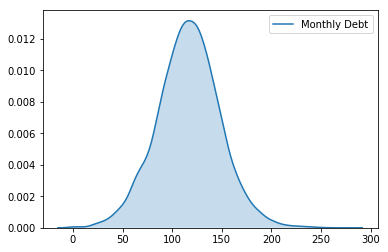

In [93]:
sns.kdeplot(df['Monthly Debt'], shade=True)

## Устранение пропущенных значений

### Устранение пропущенных значений Years in current job

In [94]:
df['Years in current job'] = df['Years in current job'].fillna(df['Years in current job'].mode()[0])

### Удаляем Months since last delinquent, так как много пропущенных значений

In [95]:
df.drop(columns=['Months since last delinquent'], axis = 1, inplace = True)

### Устранение пропущенных значений Bankruptcies

In [96]:
mode = (df['Bankruptcies'].mode())[0]
df.loc[df['Bankruptcies'].isnull(), ['Bankruptcies']] = mode

### Стандартизация данных (здесь не работает, так как бокс кокс не будет работать) реализована ниже

In [97]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit',# 'Months since last delinquent',#'new',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

In [98]:
# scaler = StandardScaler()

# df_norm = df.copy()
# df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

# df = df_norm.copy()

### Устранение пропущенных значений Current Loan Amount через регрессию

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


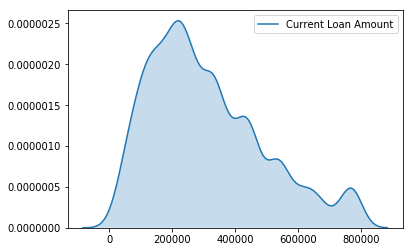

In [99]:
sns.kdeplot(df['Current Loan Amount'], shade=True)

In [100]:
test = df.loc[df['Current Loan Amount'].isnull()].drop('Current Loan Amount', axis=1)
train = df.loc[df['Current Loan Amount'].notnull()]

In [101]:
cat_features = ['Home Ownership', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems', 'Years in current job']

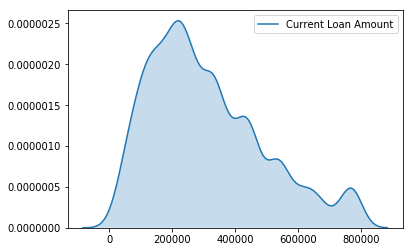

In [102]:
sns.kdeplot(train['Current Loan Amount'], shade=True)

In [103]:
model = catb.CatBoostRegressor(n_estimators=500, max_depth=3,
                                       silent=True, random_state=21, cat_features = cat_features)

In [104]:
y = train['Current Loan Amount']
X = train.drop('Current Loan Amount', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    train_size=0.8, test_size=0.2, random_state=0)

In [105]:
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

In [106]:
mae_2 = mean_absolute_error(y_valid, y_pred)

In [107]:
mae_2

103764.42872966203

In [108]:
r_2 = r2_score(y_valid, y_pred)

In [109]:
r_2

0.46586609219010167

In [110]:
model.fit(X, y)

In [111]:
result = model.predict(test)
test['Current Loan Amount'] = result
df.loc[df['Current Loan Amount'].isnull(), ['Current Loan Amount']] = test['Current Loan Amount']

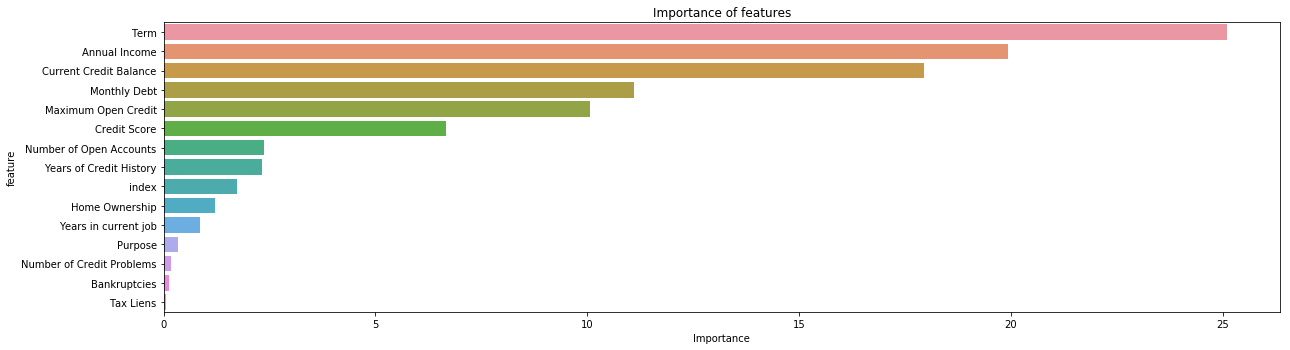

In [112]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=11)

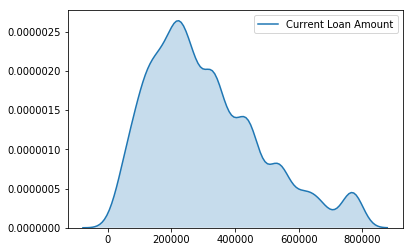

In [113]:
sns.kdeplot(df['Current Loan Amount'], shade=True)

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
index                        10000 non-null int64
Home Ownership               10000 non-null object
Annual Income                7930 non-null float64
Years in current job         10000 non-null object
Tax Liens                    10000 non-null object
Number of Open Accounts      10000 non-null float64
Years of Credit History      10000 non-null float64
Maximum Open Credit          10000 non-null float64
Number of Credit Problems    10000 non-null object
Bankruptcies                 10000 non-null float64
Purpose                      10000 non-null object
Term                         10000 non-null object
Current Loan Amount          10000 non-null float64
Current Credit Balance       10000 non-null float64
Monthly Debt                 10000 non-null float64
Credit Score                 7930 non-null float64
dtypes: float64(9), int64(1), object(6)
memory usage: 1.2+ MB


### Устранение пропущенных значений Credit Score через регрессию

In [115]:
test = df.loc[df['Credit Score'].isnull()].drop('Credit Score', axis=1)
train = df.loc[df['Credit Score'].notnull()]

In [116]:
cat_features = ['Home Ownership', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems', 'Years in current job']

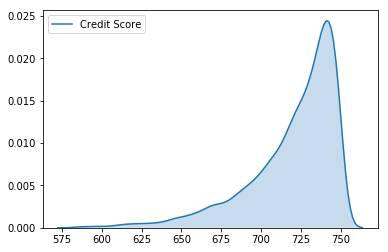

In [117]:
sns.kdeplot(train['Credit Score'], shade=True)

In [118]:
xt, _ = stats.boxcox(train['Credit Score'])

In [119]:
train['Credit Score'] = xt/1e40

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


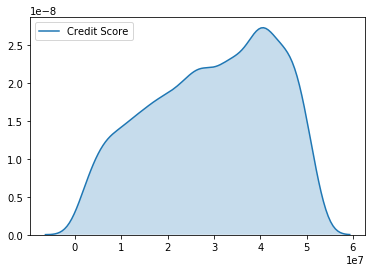

In [120]:
sns.kdeplot(train['Credit Score'], shade=True)

In [121]:
#model = catb.CatBoostRegressor(n_estimators=650, max_depth=3, #l2_leaf_reg = 0.01,
model = catb.CatBoostRegressor(n_estimators=400, max_depth=5,
                                       silent=True, random_state=21, cat_features = cat_features)

In [122]:
y = train['Credit Score']
X = train.drop('Credit Score', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    train_size=0.8, test_size=0.2, random_state=0)

In [123]:
# Обучаем на части данных, чтобы проверить точность на валидационной части
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

In [124]:
mae_2 = mean_absolute_error(y_valid, y_pred)

In [125]:
mae_2

8709489.673250545

In [126]:
r_2 = r2_score(y_valid, y_pred)

In [127]:
r_2

0.3813635691537557

In [128]:
# Обучаем на полном наборе данных, чтобы повысить точность
model.fit(X, y)

In [129]:
with open(MODEL_1_FILE_PATH, 'wb') as file:
    pickle.dump(model, file)

In [130]:
result = model.predict(test)
test['Credit Score'] = result
df.loc[df['Credit Score'].isnull(), ['Credit Score']] = test['Credit Score']
#df.loc[df['Credit Score'].isnull(), ['Credit Score']] = df['Credit Score'].median()

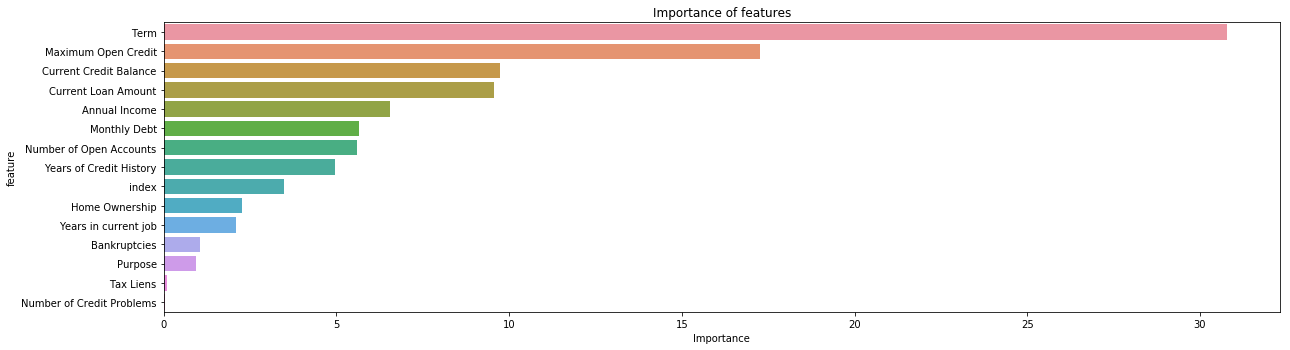

In [131]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=11)

### Устранение пропущенных значений Annual Income через регрессию

In [132]:
df.loc[df['Annual Income'] > 0.5*1e7,['Annual Income']] = df['Annual Income'].median()

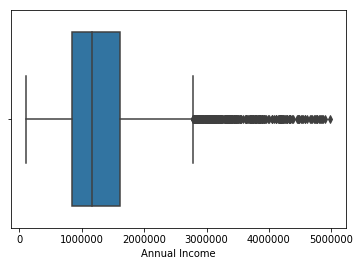

In [133]:
sns.boxplot(x=df['Annual Income'])

In [134]:
# Построим зависимость Annual Income от Monthly Debt, Current Credit Balance и Current Loan Amount
# Новый тестовый датафрейм для определения пропущенных значений Annual Income

test = df.loc[df['Annual Income'].isnull()].drop('Annual Income', axis=1)
# Новый тренировочный датафрейм для определения пропущенных значений Annual Income

train = df.loc[df['Annual Income'].notnull()]

In [135]:
cat_features = ['Home Ownership', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems', 'Years in current job']

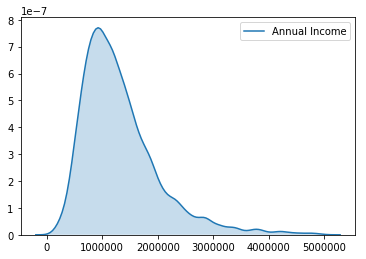

In [136]:
sns.kdeplot(train['Annual Income'], shade=True)

In [137]:
xt, _ = stats.boxcox(train['Annual Income'])

In [138]:
train['Annual Income'] = xt

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


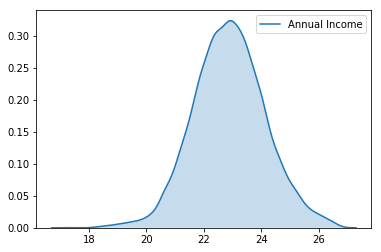

In [139]:
sns.kdeplot(train['Annual Income'], shade=True)

In [140]:
#model = catb.CatBoostRegressor(n_estimators=500, max_depth=3,
model = catb.CatBoostRegressor(n_estimators=500, max_depth=5,
                                       silent=True, random_state=21, cat_features = cat_features)

In [141]:
y = train['Annual Income']
X = train.drop('Annual Income', axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    train_size=0.8, test_size=0.2, random_state=0)

In [142]:
# Обучаем на части данных, чтобы проверить точность на валидационной части
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

In [143]:
mae_2 = mean_absolute_error(y_valid, y_pred)

In [144]:
mae_2

0.6850385300121387

In [145]:
r_2 = r2_score(y_valid, y_pred)

In [146]:
r_2

0.5233223939279001

In [147]:
# Обучаем на полном наборе данных, чтобы повысить точность
model.fit(X, y)

In [148]:
with open(MODEL_2_FILE_PATH, 'wb') as file:
    pickle.dump(model, file)

In [149]:
result = model.predict(test)
test['Annual Income'] = result
df.loc[df['Annual Income'].isnull(), ['Annual Income']] = test['Annual Income']
#df.loc[df['Annual Income'].isnull(), ['Annual Income']] = df['Annual Income'].median()

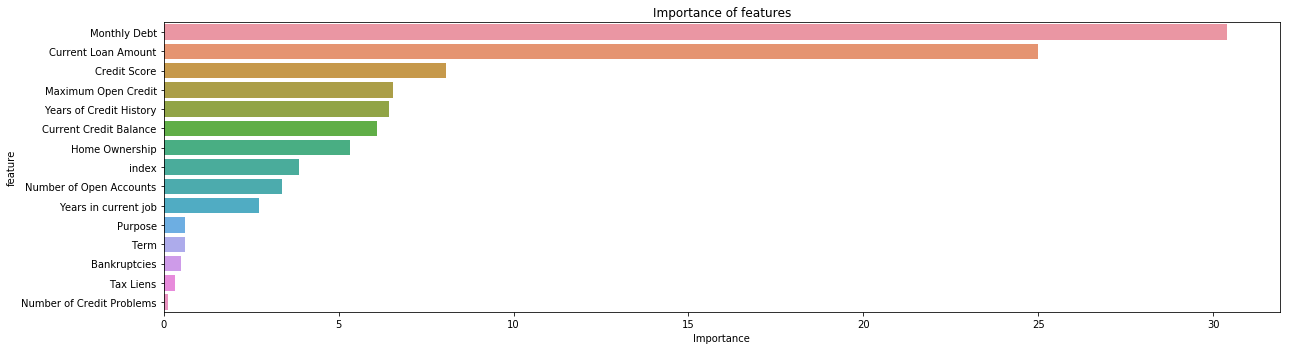

In [150]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=11)

#### Уменьшение числа признаков не привело к повышению точности

## Разделение на train и test

In [151]:
df_train = df.iloc[0:7500,:].drop('index', axis=1)

In [152]:
df_train.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
7495,Rent,4.021920e+05,< 1 year,Less_equ_1,1.259180,2.457808,107866.0,Less_equ_3,0.0,Class2,Short Term,129360.000000,73492.0,48.288903,6.970000e+02
7496,Home Mortgage,1.533984e+06,1 year,Less_equ_1,3.085544,4.061032,686312.0,Less_equ_3,0.0,Class2,Long Term,444048.000000,456399.0,106.018208,7.410000e+02
7497,Rent,1.878910e+06,6 years,Less_equ_1,3.411702,4.354792,1778920.0,Less_equ_3,0.0,Class2,Short Term,360969.734145,477812.0,104.982774,7.480000e+02
7498,Home Mortgage,2.466989e+01,10+ years,Less_equ_1,4.507975,4.061032,1141250.0,Less_equ_3,0.0,Class2,Short Term,615274.000000,476064.0,163.425334,1.054191e+07
7499,Rent,2.223304e+01,4 years,Less_equ_1,2.705527,2.590591,480832.0,Less_equ_3,0.0,Class2,Short Term,26928.000000,288192.0,92.117168,2.184704e+07


In [153]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 15 columns):
Home Ownership               7500 non-null object
Annual Income                7500 non-null float64
Years in current job         7500 non-null object
Tax Liens                    7500 non-null object
Number of Open Accounts      7500 non-null float64
Years of Credit History      7500 non-null float64
Maximum Open Credit          7500 non-null float64
Number of Credit Problems    7500 non-null object
Bankruptcies                 7500 non-null float64
Purpose                      7500 non-null object
Term                         7500 non-null object
Current Loan Amount          7500 non-null float64
Current Credit Balance       7500 non-null float64
Monthly Debt                 7500 non-null float64
Credit Score                 7500 non-null float64
dtypes: float64(9), object(6)
memory usage: 879.0+ KB


In [154]:
df_test = df.iloc[7500:,:].drop('index', axis=1).reset_index().drop('index', axis=1)

In [155]:
df_test.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1.020053e+06,10+ years,Less_equ_1,3.698962,4.203556,559152.0,Less_equ_3,1.0,Class2,Short Term,224786.70146,162735.0,113.297672,7.450000e+02
2496,Home Mortgage,2.488101e+01,2 years,Less_equ_1,3.831057,3.407532,1737780.0,Less_equ_3,0.0,Class2,Short Term,468512.00000,1439269.0,155.824593,1.140552e+07
2497,Home Mortgage,1.171806e+06,2 years,Less_equ_1,6.426166,3.008629,1706430.0,Less_equ_3,0.0,Class2,Short Term,430496.00000,676438.0,163.057905,6.950000e+02
2498,Rent,7.235200e+05,10+ years,Less_equ_1,3.698962,4.187692,945780.0,Less_equ_3,0.0,Class2,Short Term,257774.00000,391248.0,108.422671,7.440000e+02
2499,Rent,1.694439e+06,10+ years,Less_equ_1,3.411702,3.521356,1199748.0,Less_equ_3,0.0,Class2,Long Term,763004.00000,559531.0,135.663669,6.820000e+02


In [156]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
Home Ownership               2500 non-null object
Annual Income                2500 non-null float64
Years in current job         2500 non-null object
Tax Liens                    2500 non-null object
Number of Open Accounts      2500 non-null float64
Years of Credit History      2500 non-null float64
Maximum Open Credit          2500 non-null float64
Number of Credit Problems    2500 non-null object
Bankruptcies                 2500 non-null float64
Purpose                      2500 non-null object
Term                         2500 non-null object
Current Loan Amount          2500 non-null float64
Current Credit Balance       2500 non-null float64
Monthly Debt                 2500 non-null float64
Credit Score                 2500 non-null float64
dtypes: float64(9), object(6)
memory usage: 293.0+ KB


## Разделение признаков

In [157]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit',# 'Months since last delinquent',#'new',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term', 'Tax Liens', 'Number of Credit Problems', 'Years in current job']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES
TARGET_NAME = 'Credit Default'

In [158]:
X = df_train[SELECTED_FEATURE_NAMES]
#y = df_train[TARGET_NAME]

## Стандартизация данных (не дала прироста точности)

In [159]:
# scaler = StandardScaler()

# df_norm = df_train.copy()
# df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

# df_train = df_norm.copy()

In [160]:
X = df_train[SELECTED_FEATURE_NAMES]
#y = df_train[TARGET_NAME]

## Разбиение на train и valid

In [161]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_df, shuffle=True, test_size=0.30, random_state=12)

In [162]:
#X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, shuffle=True, test_size=0.30, random_state=21)

## Балансировка целевой переменной через библиотеку

Чтобы наиболее правильно оценить работу алгоритма, производить балансировку нужно после разбиения на train и valid.

Если произвести балансировку до разбиения, то дубликаты попадут и в train и в valid. И точность итогового алгоритма будет завышена.

In [163]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=21)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

from collections import Counter
print(sorted(Counter(y_resampled).items()))
X_train = X_resampled
y_train = y_resampled

[(0, 3759), (1, 3759)]


In [164]:
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
# df_balanced[TARGET_NAME].value_counts()

In [165]:
# X_train = df_balanced.drop(columns=TARGET_NAME)
# y_train = df_balanced[TARGET_NAME]

## Построение модели catBoost

In [166]:
model_catb = catb.CatBoostClassifier(n_estimators=550, max_depth=4, l2_leaf_reg=10,
                                      silent=True, random_state=21, cat_features = CAT_FEATURE_NAMES, 
                                     class_weights=[1, 0.7])
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.87      0.75      3759
           1       0.81      0.54      0.64      3759

    accuracy                           0.70      7518
   macro avg       0.73      0.70      0.69      7518
weighted avg       0.73      0.70      0.69      7518

TEST

              precision    recall  f1-score   support

           0       0.78      0.84      0.80      1628
           1       0.46      0.37      0.41       622

    accuracy                           0.71      2250
   macro avg       0.62      0.60      0.61      2250
weighted avg       0.69      0.71      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1360  268
1                393  229


## Отбор признаков

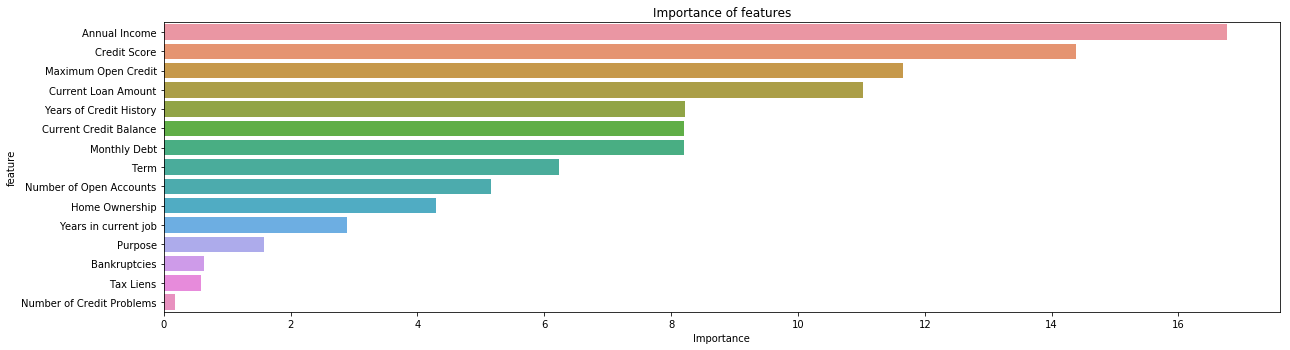

In [167]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [168]:
important_features_top

['Annual Income',
 'Credit Score',
 'Maximum Open Credit',
 'Current Loan Amount',
 'Years of Credit History',
 'Current Credit Balance',
 'Monthly Debt',
 'Term',
 'Number of Open Accounts',
 'Home Ownership',
 'Years in current job',
 'Purpose',
 'Bankruptcies',
 'Tax Liens',
 'Number of Credit Problems']

In [169]:
cat_features = list(set(CAT_FEATURE_NAMES) & set(important_features_top))

In [170]:
cat_features

['Home Ownership',
 'Years in current job',
 'Purpose',
 'Number of Credit Problems',
 'Term',
 'Tax Liens']

In [171]:
model_catb = catb.CatBoostClassifier(n_estimators=500, max_depth=3,
                                        # это были лучшие параметры без балансировки целевой переменной
                                      #silent=True, random_state=21, cat_features = cat_features, class_weights=[1, 2.56])
                                     # это были лучшие параметры с балансировкой целевой переменной
                                     silent=True, random_state=21, cat_features = cat_features, class_weights=[1, 0.7])
                                     #silent=True, random_state=21, cat_features = cat_features, class_weights=[1, 1.27])
model_catb.fit(X_train[important_features_top], y_train)

y_train_pred = model_catb.predict(X_train[important_features_top])
y_valid_pred = model_catb.predict(X_valid[important_features_top])
y_test_pred_probs = model_catb.predict_proba(X_valid[important_features_top])

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.86      0.73      3759
           1       0.79      0.51      0.62      3759

    accuracy                           0.69      7518
   macro avg       0.71      0.69      0.68      7518
weighted avg       0.71      0.69      0.68      7518

TEST

              precision    recall  f1-score   support

           0       0.77      0.82      0.80      1628
           1       0.44      0.36      0.39       622

    accuracy                           0.70      2250
   macro avg       0.60      0.59      0.60      2250
weighted avg       0.68      0.70      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1341  287
1                399  223


In [172]:
y_p = np.array(y_test_pred_probs[:,1]>0.5).astype('int') #>0.55

get_classification_report(y_train, y_train_pred, y_valid, y_p)

TRAIN

              precision    recall  f1-score   support

           0       0.64      0.86      0.73      3759
           1       0.79      0.51      0.62      3759

    accuracy                           0.69      7518
   macro avg       0.71      0.69      0.68      7518
weighted avg       0.71      0.69      0.68      7518

TEST

              precision    recall  f1-score   support

           0       0.77      0.82      0.80      1628
           1       0.44      0.36      0.39       622

    accuracy                           0.70      2250
   macro avg       0.60      0.59      0.60      2250
weighted avg       0.68      0.70      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1341  287
1                399  223


## Получение результата

### Балансировка целевой переменной

In [173]:
ros = RandomOverSampler(random_state=21)
X_resampled, y_resampled = ros.fit_resample(X, y_df)

In [174]:
print(sorted(Counter(y_resampled).items()))
X = X_resampled
y_df = y_resampled

[(0, 5387), (1, 5387)]


### Обучение итоговой модели и сохранеие результата

In [175]:
model_catb.fit(X[important_features_top], y_df)

In [176]:
with open(MODEL_3_FILE_PATH, 'wb') as file:
    pickle.dump(model_catb, file)

In [177]:
df_test['Credit Default'] = model_catb.predict(df_test[important_features_top])

In [178]:
df_test.loc[:, ['Credit Default']].head()

,Credit Default
0,0
1,1
2,0
3,0
4,0


In [179]:
# Сохранение результата, полученного на тестовой выборке
df_test.loc[:, ['Credit Default']].to_csv('DFedorov_predictions.csv', index=None)

In [180]:
# Получение результата на тренировочной выборке для мониторинга точности
y_train_pred = model_catb.predict(X[important_features_top])

In [181]:
print('TRAIN\n\n' + classification_report(y_df, y_train_pred))

TRAIN

              precision    recall  f1-score   support

           0       0.62      0.86      0.72      5387
           1       0.77      0.48      0.59      5387

    accuracy                           0.67     10774
   macro avg       0.70      0.67      0.65     10774
weighted avg       0.70      0.67      0.65     10774

